# Build a catalog for CESM1 timeseries output

## Imports
First, we import the `Builder` object and the parser we are using, in this case, `parse_cesm_timeseries`!

In [1]:
from ecgtools import Builder
from ecgtools.parsers.cesm import parse_cesm_timeseries

## Setup the Builder
In this example, we are using sample CESM model output stored in `/glade/work/mgrover/cesm_test_data/b.e20.B1850.f19_g17.test/`

In [2]:
b = Builder(
    # Where to look for model output
    "/glade/campaign/univ/udeo0005/cesmLE_no_pinatubo/",
    depth=5,
    exclude_patterns=["*/hist/*", "*/rest/*"],
    njobs=-1,
)

## Configuring the parser
Since we are working with CESM1 model output, we will specify the stream information to ensure the parser is adding the correct information to our catalog

Notice how the parser takes in two arguments, the `file` and `user_streams_dict`

The `user_streams_dict` allows us to customize the stream information

In [3]:
?parse_cesm_timeseries

Signature: parse_cesm_timeseries(file, user_streams_dict={})
Docstring: Parser for CESM Timeseries files
File:      /glade/work/mgrover/git_repos/ecgtools/ecgtools/parsers/cesm.py
Type:      function


We setup a dictionary formatted in the following way - this is a good practice to investigate which streams are included in your CESM model output, their associated components, and the frequency. Since this CESM1, the `frequency` information is not stored within the attributes, which means the parser will use the [`default_streams` dictionary](https://github.com/mgrover1/ecgtools/blob/main/ecgtools/parsers/cesm.py#L12#L58) to parse the files and assign metadata within the catalog

In [4]:
stream_info = {
    'cam.h0': {'component': 'atm', 'frequency': 'month_1'},
    'cam.h1': {'component': 'atm', 'frequency': 'day_1'},
    'cam.h2': {'component': 'atm', 'frequency': 'hour_6'},
    'cice.h': {'component': 'ice', 'frequency': 'month_1'},
    'cice.h1': {'component': 'ice', 'frequency': 'day_1'},
    'clm2.h0': {'component': 'lnd', 'frequency': 'month_1'},
    'clm2.h1': {'component': 'lnd', 'frequency': 'day_1'},
    'pop.h.ecosys.nyear1': {'component': 'ocn', 'frequency': 'year_1'},
    'pop.h.nday1': {'component': 'ocn', 'frequency': 'day_1'},
    'pop.h': {'component': 'ocn', 'frequency': 'month_1'},
}

## Build the catalog
Now that we setup our `stream_info` dictionary, we feed the parser (`parse_cesm_timeseries`) and the `stream_info` dictionary into the `.build()` call, using the following syntax

In [5]:
b.build(parse_cesm_timeseries, parsing_func_kwargs={'user_streams_dict': stream_info})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 36 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 36 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 378 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 576 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 810 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 1080 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 1386 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 1728 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 2106 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 2520 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 2970 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 3888 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: D

Builder(root_path=PosixPath('/glade/campaign/univ/udeo0005/cesmLE_no_pinatubo'), extension='.nc', depth=5, exclude_patterns=['*/hist/*', '*/rest/*'], njobs=-1)

## Inspect the catalog

It looks like the primary files missed were zonally averaged timeseries files, which for now, we are not concerned about dealing with 

In [8]:
b.save(
    '/glade/work/mgrover/intake-esm-catalogs/pinatubo-LE.csv',
    # Column name including filepath
    path_column_name='path',
    # Column name including variables
    variable_column_name='variable',
    # Data file format - could be netcdf or zarr (in this case, netcdf)
    data_format="netcdf",
    # Which attributes to groupby when reading in variables using intake-esm
    groupby_attrs=["component", "stream", "case"],
    # Aggregations which are fed into xarray when reading in data using intake
    aggregations=[
        {
            "type": "join_existing",
            "attribute_name": "time_range",
            "options": {"dim": "time", "coords": "minimal", "compat": "override"},
        }
    ],
)

Saved catalog location: /glade/work/mgrover/intake-esm-catalogs/pinatubo-LE.json and /glade/work/mgrover/intake-esm-catalogs/pinatubo-LE.csv


/glade/u/home/mgrover/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Unable to parse 1950 assets/files. A list of these assets can be found in /glade/work/mgrover/intake-esm-catalogs/invalid_assets_pinatubo-LE.csv.


## Test the Catalog

In [9]:
import intake

In [10]:
col = intake.open_esm_datastore('/glade/work/mgrover/intake-esm-catalogs/pinatubo-LE.json')

In [11]:
col.df.stream.unique()

array(['cam.h1', 'cam.h0', 'pop.h.ecosys.nday1', 'pop.h.nday1',
       'pop.h.ecosys.nyear1', 'pop.h', 'clm2.h1', 'clm2.h0', 'rtm.h1',
       'rtm.h0', 'cice.h1', 'cice.h'], dtype=object)

In [12]:
cat = col.search(variable='TEMP', frequency='month_1')

In [13]:
dsets = cat.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.stream.case'


In [16]:
ds = dsets['ocn.pop.h.b.e11.BRCP85C5CNBDRD_no_pinatubo.f09_g16.009']

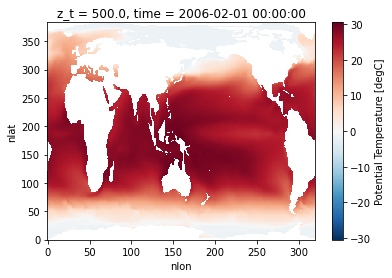

In [18]:
ds.TEMP.isel(time=0, z_t=0).plot()